# Packages needed

In [2]:
# Data procesing, description and ploting
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tableone import TableOne as to

# Data preprocessing
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer,SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin

# Feature selection 
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif, mutual_info_classif, SelectFromModel, RFE 
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LassoCV, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, cross_val_score


# Load  data from the two different Excel files

In [3]:
## Clinical data
df_clinical = pd.read_excel('E:\TFM Marta\Base de dades\RadioponPulmon_SBRT_TFM v6.xlsx')
df_clinical.rename(columns={"RESPUESTA POR TC A 1.5 MESES": "RESPONSE","ID TFM Marta":"ID" }, inplace=True)
df_clinical['ID'] = df_clinical['ID'].astype(float)
print(f"Clinical dataframe shape: {df_clinical.shape}")

## Radiomic data
df_radiomic = pd.read_excel('E:\TFM Marta\Codis\Radiomics_Marta.xlsx')
df_radiomic['case_id'] = df_radiomic['case_id'].str.replace('_MCC$', '', regex=True)
df_radiomic.rename(columns={"case_id": "ID" }, inplace=True)
df_radiomic['ID'] = df_radiomic['ID'].astype(float)
print(f"Radiomic dataframe shape: {df_radiomic.shape}")

# Merging dataframes and filtering ID present in both
df_common = pd.merge(df_clinical[['ID']], df_radiomic[['ID']], on='ID', how='inner') 
df_clinical = df_clinical[df_clinical['ID'].isin(df_common['ID'])]
df_radiomic = df_radiomic[df_radiomic['ID'].isin(df_common['ID'])]

df_clinical.reset_index(drop=True, inplace=True)
df_radiomic.reset_index(drop=True, inplace=True)

print(f"Common ID dataframe shape: {df_common.shape}")
print(f"Clinical dataframe reshaped: {df_clinical.shape}")
print(f"Radiomic dataframe reshaped: {df_radiomic.shape}")

Clinical dataframe shape: (148, 35)
Radiomic dataframe shape: (153, 1690)
Common ID dataframe shape: (141, 1)
Clinical dataframe reshaped: (141, 35)
Radiomic dataframe reshaped: (141, 1690)


# Clinical data preprocessing (before data splitting)

Index(['Fecha nacimiento', 'FECHA INICIO RT', 'FECHA FINAL RT',
       'FECHA DE EXITUS', 'ÚLTIMO CONTROL', 'FECHA DE RECAIDA'],
      dtype='object')


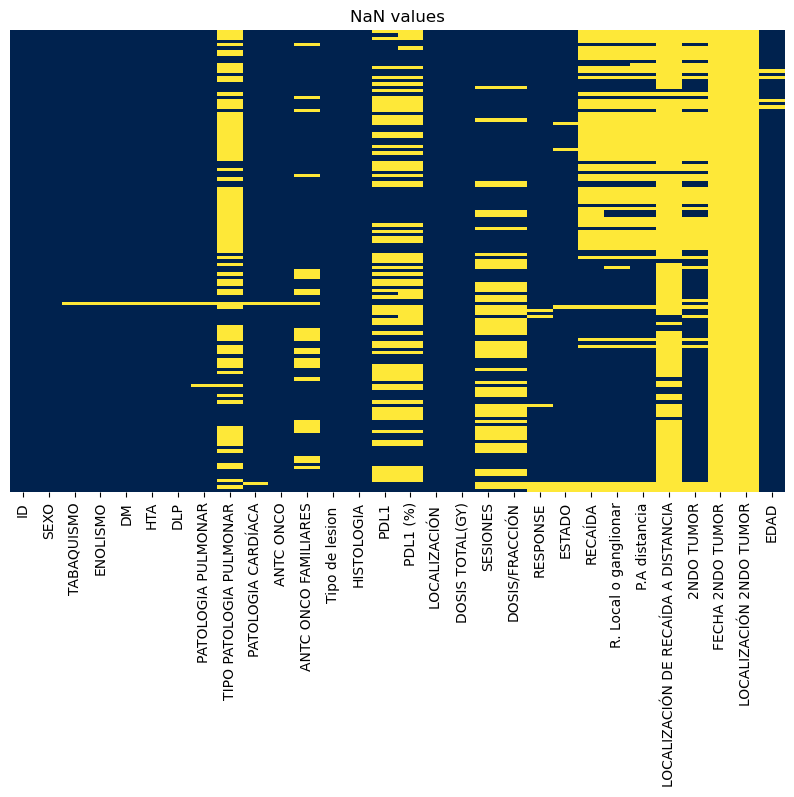

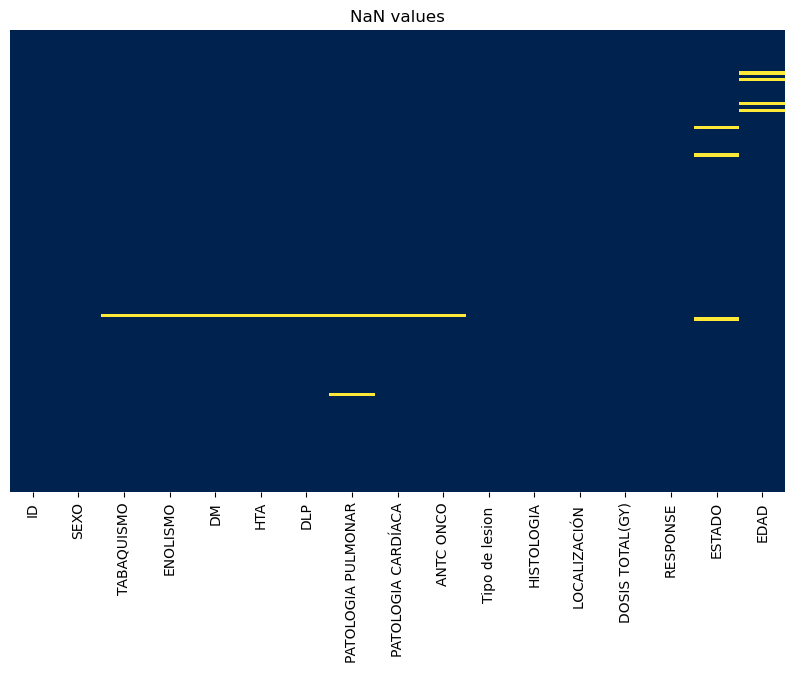

clinical filtered  (135, 17)


In [4]:
## Rename columns
df_clinical.rename(columns={"RESPUESTA POR TC A 1.5 MESES": "RESPONSE","ID TFM Marta":"ID" }, inplace=True)

## Age calculation
df_clinical['EDAD'] = (df_clinical['FECHA INICIO RT'] - df_clinical['Fecha nacimiento']).dt.days // 365

## Date variables elimination 
date_columns = df_clinical.select_dtypes(include=['datetime']).columns
print(date_columns)
df_clinical.drop(columns=date_columns, inplace=True)

## "No consta" relabeling to NA 
df_clinical.replace('No consta', np.nan, inplace=True)

## NAs count 
plt.figure(figsize=(10, 6))
sns.heatmap(df_clinical.isna(), cbar=False, cmap='cividis', yticklabels=False)
plt.title('NaN values')
plt.show()

## Variable filtering
if df_clinical.isna().sum().sum() > 0:
    #Since we want to predict response, drop registies without response value
    df_clinical_filtred = df_clinical.dropna(subset=['RESPONSE'], inplace=True) 

    #Filter columns with more than a 10% of missing values
    nan_percentage = (df_clinical.isna().sum() / len(df_clinical)) * 100
    df_clinical_filtred = df_clinical.loc[:, nan_percentage < 10]

    #Plot the result
    plt.figure(figsize=(10, 6))
    sns.heatmap(df_clinical_filtred.isna(), cbar=False, cmap='cividis', yticklabels=False)
    plt.title('NaN values')
    plt.show()

else:
    df_clinical_filtred = df_clinical
    print("No NA values in the DataFrame.")

print("clinical filtered ", df_clinical_filtred.shape)

# Clinical data description

In [5]:
df_clinical_data = df_clinical_filtred.drop(columns="ID")
numeric_variables = df_clinical_data.select_dtypes(include=['number']).columns
numeric_variables = numeric_variables.tolist()

categoric_variables = df_clinical_data.select_dtypes(include=['object', 'category']).columns
categoric_variables = categoric_variables.tolist()

table = to(df_clinical_data, categorical=categoric_variables, pval=False, nonnormal=numeric_variables)
print(table.tabulate(tablefmt = "fancy_grid"))
table.to_excel('descriptive_clinical.xlsx')

╒═════════════════════════════════╤══════════════════════════╤═══════════╤══════════════════╕
│                                 │                          │ Missing   │ Overall          │
╞═════════════════════════════════╪══════════════════════════╪═══════════╪══════════════════╡
│ n                               │                          │           │ 135              │
├─────────────────────────────────┼──────────────────────────┼───────────┼──────────────────┤
│ SEXO, n (%)                     │ Hombre                   │           │ 102 (75.6)       │
├─────────────────────────────────┼──────────────────────────┼───────────┼──────────────────┤
│                                 │ Mujer                    │           │ 33 (24.4)        │
├─────────────────────────────────┼──────────────────────────┼───────────┼──────────────────┤
│ TABAQUISMO, n (%)               │ Ex                       │           │ 47 (34.8)        │
├─────────────────────────────────┼─────────────────────────

# Data splitting

In [6]:
#Response variable to binary
df_clinical_filtred.loc[:, "RESPONSE"] = df_clinical_filtred["RESPONSE"].replace(
    {"Completa": 1, "Parcial ": 1, "Estable": 0, "Progresión": 0}
).astype(int)

df_clinical_filtred = df_clinical_filtred.drop(columns="ESTADO")
#Predictive variables
X = df_clinical_filtred.drop('RESPONSE', axis=1)

#Predicted variable
y = df_clinical_filtred['RESPONSE']  

## Training (80%) and testing (20%) splitting 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2024, stratify=y)

## Output dimensions
print(f'Training dataset: {X_train.shape}')
print(f'Testing dataset: {X_test.shape}') 

Training dataset: (108, 15)
Testing dataset: (27, 15)


C:\Users\pcbox\AppData\Local\Temp\ipykernel_9112\1985012860.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_clinical_filtred.loc[:, "RESPONSE"] = df_clinical_filtred["RESPONSE"].replace(


# Clinical data preprocessing (after data splitting) 
## Data imputation

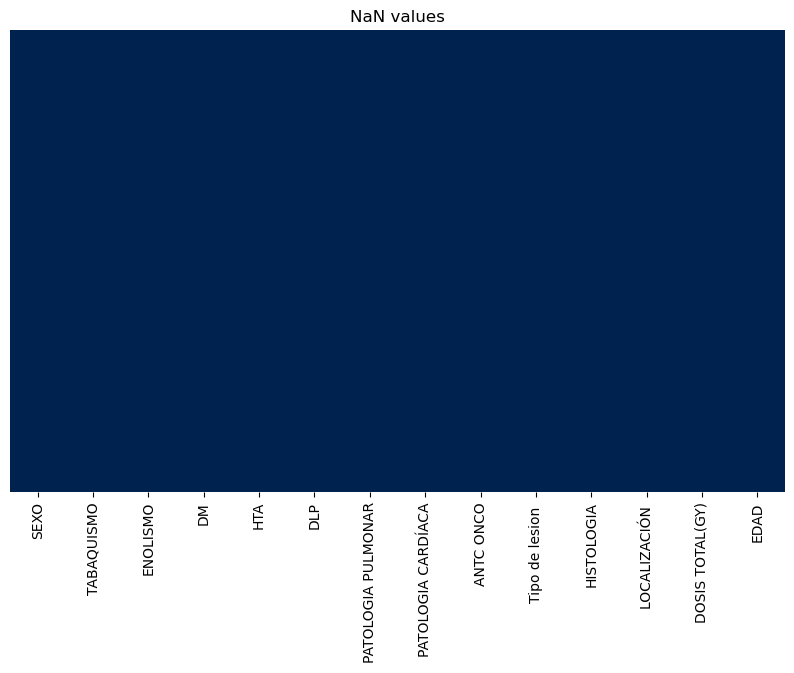

In [7]:
## Numeric data imputation 
X_train_data = X_train.drop(columns="ID")
X_test_data = X_test.drop(columns="ID")
numeric_variables = X_train_data.select_dtypes(include=['number']).columns
numeric_variables = numeric_variables.tolist()

num_imp= KNNImputer(n_neighbors=3)
X_train_data[numeric_variables] = num_imp.fit_transform(
    X_train_data[numeric_variables]
)
X_test_data[numeric_variables] = num_imp.transform(X_test_data[numeric_variables])

## Categoric data imputation 
categoric_variables = X_train_data.select_dtypes(include=['object', 'category']).columns
categoric_variables = categoric_variables.tolist()

cat_imp= SimpleImputer(strategy='most_frequent') 
X_train_data[categoric_variables] = cat_imp.fit_transform(
    X_train_data[categoric_variables]
)
X_test_data[categoric_variables] = cat_imp.transform(X_test_data[categoric_variables])

### Plot after data imputation
plt.figure(figsize=(10, 6))
sns.heatmap(X_train_data.isna(), cbar=False, cmap='cividis', yticklabels=False)
plt.title('NaN values')
plt.show()

## Data one-hot encoding

In [8]:
## One-hot encoding 
X_train_encoded = pd.get_dummies(X_train_data, columns=categoric_variables, drop_first=True, dtype=int)
X_test_encoded = pd.get_dummies(X_test_data, columns=categoric_variables, drop_first=True, dtype=int)
X_test_encoded = X_test_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)


In [9]:
X_train_encoded.shape

(108, 22)

# Radiomic data preprocessing (before data splitting)

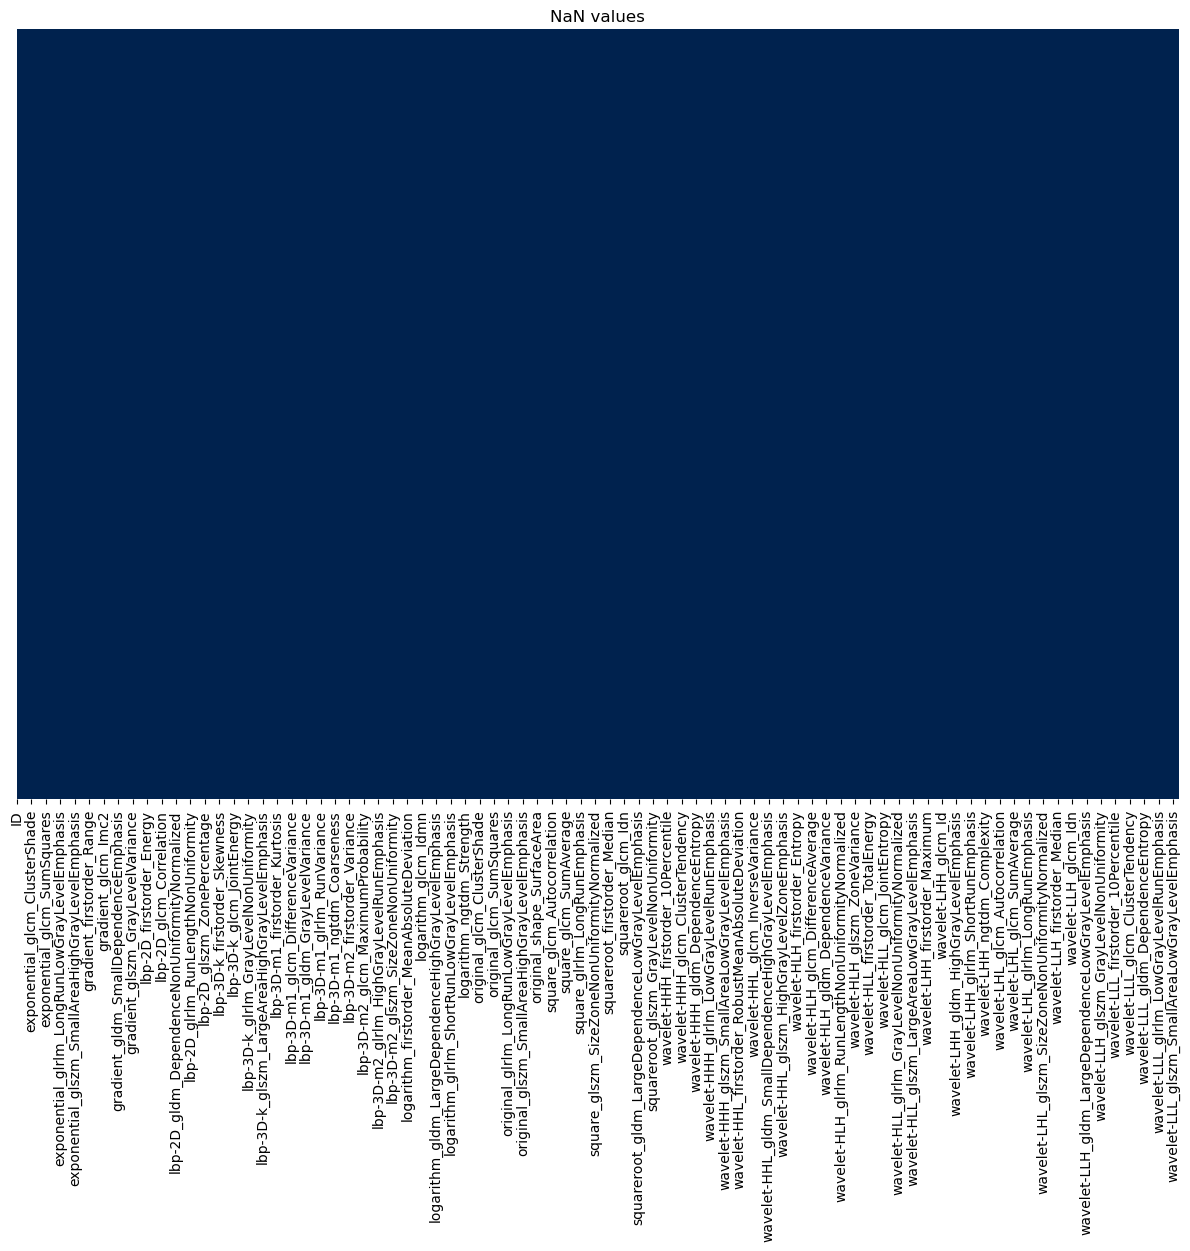

No NA values in the DataFrame.


In [10]:
#Eliminate index column
df_radiomic = df_radiomic.drop(df_radiomic.columns[0], axis=1)

## NAs count 
plt.figure(figsize=(15, 10))
sns.heatmap(df_radiomic.isna(), cbar=False, cmap='cividis', yticklabels=False)
plt.title('NaN values')
plt.show()

## Variable filtering
if df_radiomic.isna().sum().sum() > 0:
    nan_percentage = (df_radiomic.isna().sum() / len(df_radiomic)) * 100
    df_radiomic_filtred = df_radiomic.loc[:, nan_percentage < 10]

    plt.figure(figsize=(15, 10))
    sns.heatmap(df_radiomic_filtred.isna(), cbar=False, cmap='cividis', yticklabels=False)
    plt.title('NaN values')
    plt.show()
else:
    df_radiomic_filtred = df_radiomic
    print("No NA values in the DataFrame.")

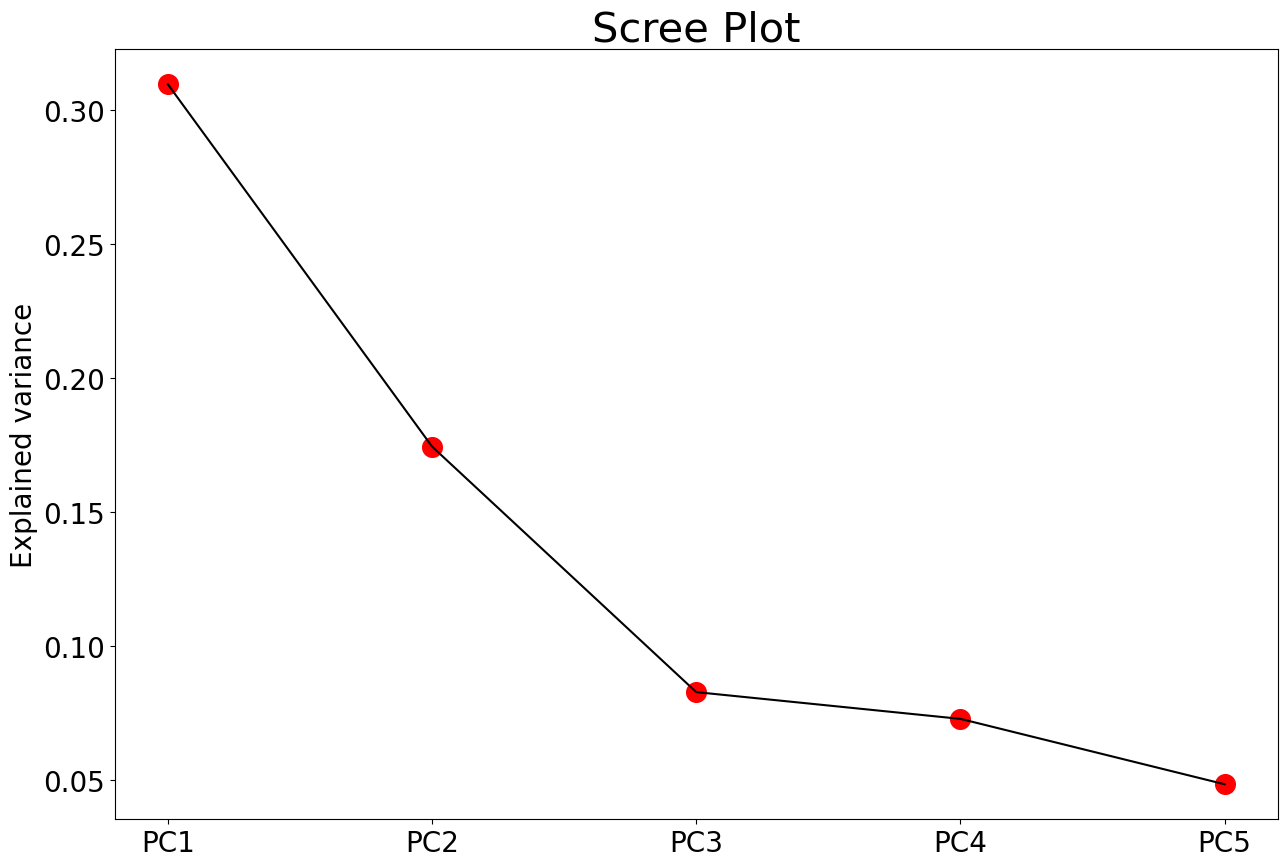

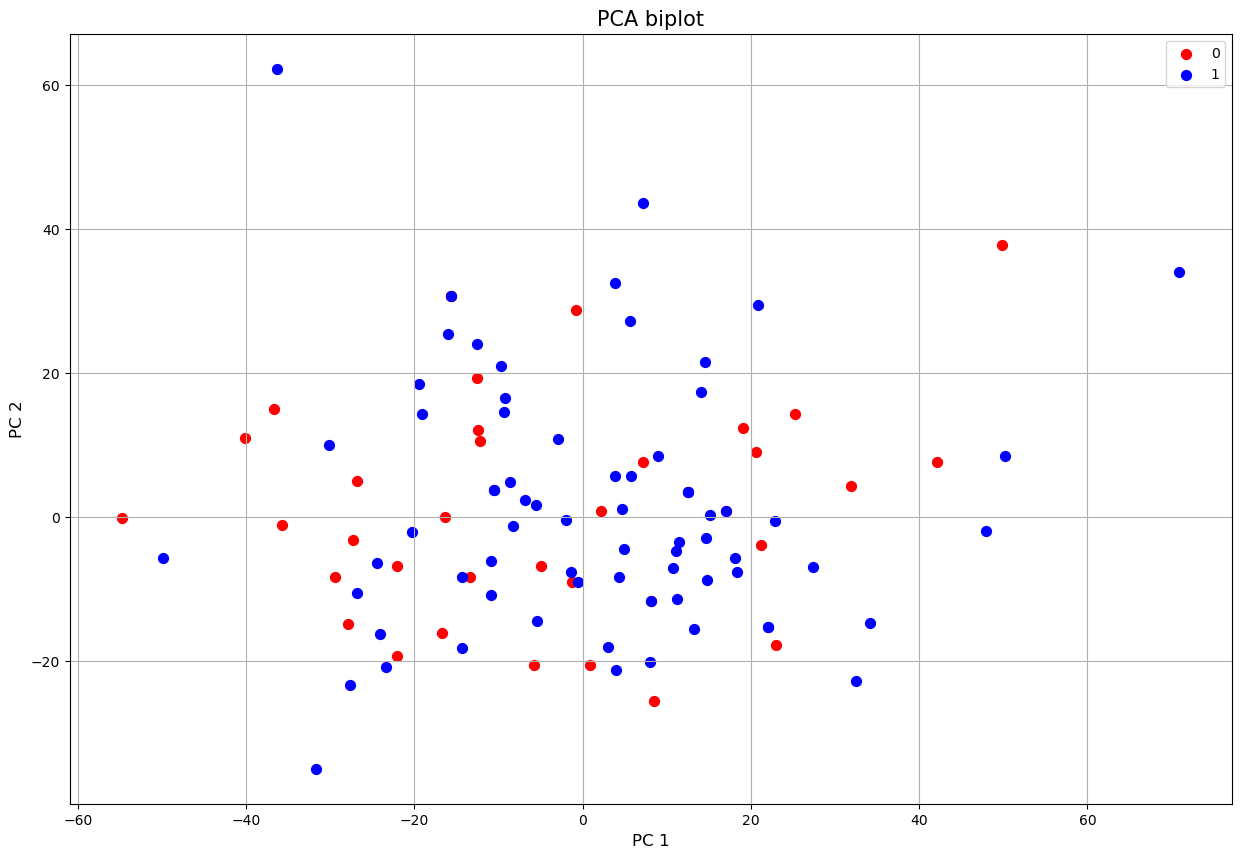

In [11]:
pca = PCA(n_components=5)
scaler = StandardScaler()
df_radiomic_scaled = scaler.fit_transform(df_radiomic)

# Scree plot
pca = PCA(n_components=5)
pca_fit = pca.fit_transform(df_radiomic_scaled)
pca_fit_df = pd.DataFrame(data = pca_fit,
                          columns = ['principal component 1',
                                     'principal component 2',
                                     'principal component 3',
                                     'principal component 4',
                                     'principal component 5'])
pca_fit_df['response'] = y_train

fig, ax = plt.subplots(figsize=(15, 10))
plt.scatter(np.arange(len(pca.explained_variance_ratio_)),
            pca.explained_variance_ratio_, color='red', s=200)
plt.plot(np.arange(len(pca.explained_variance_ratio_)),
         pca.explained_variance_ratio_, color='black')
plt.xticks(np.arange(len(pca.explained_variance_ratio_)),
           ['PC'+str(i) for i in range(1,6)], fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('Explained variance', fontsize=20)
plt.title('Scree Plot',fontsize=30)
plt.show()

fig = plt.figure(figsize = (15,10))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('PC 1', fontsize = 12)
ax.set_ylabel('PC 2', fontsize = 12)
ax.set_title('PCA biplot', fontsize = 15)
diags=[0,1]
colors=['r','b']
for diag, color in zip(diags,colors):
    i = pca_fit_df['response'] == diag
    ax.scatter(pca_fit_df.loc[i, 'principal component 1']
               , pca_fit_df.loc[i, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(diags)
ax.grid()

# Radiomic data splitting

In [12]:
df_radiomic_train = df_radiomic_filtred[df_radiomic_filtred['ID'].isin(X_train['ID'])]
df_radiomic_test = df_radiomic_filtred[df_radiomic_filtred['ID'].isin(X_test['ID'])]

df_radiomic_train_data = df_radiomic_filtred.drop(columns='ID')
df_radiomic_test_data = df_radiomic_filtred.drop(columns='ID')

# Radiomic data preprocessing (after data splitting)

In [13]:
#Data preprocessing
##  Selection of discriminant and non redundant features
var = VarianceThreshold(threshold=0)  
df_radiomic_train_data_filter = var.fit_transform(df_radiomic_train_data)
df_radiomic_train_data_filter = pd.DataFrame(df_radiomic_train_data_filter, columns=df_radiomic_train_data.columns[var.get_support()])
print(f"Remaining features: {df_radiomic_train_data_filter.shape[1]}")

df_radiomic_test_data_filter = var.transform(df_radiomic_test_data)
df_radiomic_test_data_filter = pd.DataFrame(df_radiomic_test_data_filter, columns=df_radiomic_test_data.columns[var.get_support()])

X_train_reduced = df_radiomic_train_data_filter
X_test_reduced = df_radiomic_test_data_filter

print(f"Remaining features: {X_train_reduced.shape[1]}")
print(f"Remaining features: {X_test_reduced.shape[1]}")

Remaining features: 1558
Remaining features: 1558
Remaining features: 1558


# DATA MERGING

In [14]:
# Resetting indexes
## Training set
df_radiomic_train = df_radiomic_train.reset_index(drop=True)
X_train_reduced = X_train_reduced.reset_index(drop=True)
X_train = X_train.reset_index(drop=True)
X_train_encoded = X_train_encoded.reset_index(drop=True)

## Testing set
df_radiomic_test = df_radiomic_test.reset_index(drop=True)
X_test_reduced = X_test_reduced.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
X_test_encoded = X_test_encoded.reset_index(drop=True)

# Concatenating IDs
## Training set
training_clinical = pd.concat([X_train[['ID']], X_train_encoded], axis=1)
training_radiomic = pd.concat([df_radiomic_train[['ID']], X_train_reduced], axis=1)

### Ensuring the same ID type data in both dataframes
training_radiomic['ID'] = training_radiomic['ID'].astype(float)
training_clinical['ID'] = training_clinical['ID'].astype(float)

## Testing set
testing_clinical = pd.concat([X_test[['ID']], X_test_encoded], axis=1)
testing_radiomic = pd.concat([df_radiomic_test[['ID']], X_test_reduced], axis=1)

### Ensuring the same ID type data in both dataframes
testing_radiomic['ID'] = testing_radiomic['ID'].astype(float)
testing_clinical['ID'] = testing_clinical['ID'].astype(float)
testing_radiomic['ID'] = testing_radiomic['ID'].astype(float)
testing_clinical['ID'] = testing_clinical['ID'].astype(float)

# Df merging by ID
df_total_train = pd.merge(training_clinical, training_radiomic, on='ID', how='inner')
df_total_test = pd.merge(testing_clinical, testing_radiomic, on='ID', how='inner')
print(f'Merged dataset shape (train): {df_total_train.shape}')
print(f'Merged dataset shape (test): {df_total_test.shape}')

# Drop the "ID" column
df_total_train_data = df_total_train.drop(columns="ID")
df_total_test_data = df_total_test.drop(columns="ID")

# Check if the shapes are still correct after dropping "ID"
print(f"Training data shape (after dropping 'ID'): {df_total_train_data.shape}")
print(f"Testing data shape (after dropping 'ID'): {df_total_test_data.shape}")

# Make sure y is correctly set
y_train = y_train.astype(int)
y_test = y_test.astype(int)

print(f"Training set shape after scaling: {df_total_train_data.shape}")
print(f"Testing set shape after scaling: {df_total_test_data.shape}")

Merged dataset shape (train): (108, 1581)
Merged dataset shape (test): (27, 1581)
Training data shape (after dropping 'ID'): (108, 1580)
Testing data shape (after dropping 'ID'): (27, 1580)
Training set shape after scaling: (108, 1580)
Testing set shape after scaling: (27, 1580)


In [15]:
df_total_train_data.describe()

,DOSIS TOTAL(GY),EDAD,SEXO_Mujer,TABAQUISMO_No,TABAQUISMO_Si,ENOLISMO_No,ENOLISMO_Si,DM_Si,HTA_Si,DLP_Si,...,wavelet-LLL_glszm_SmallAreaHighGrayLevelEmphasis,wavelet-LLL_glszm_SmallAreaLowGrayLevelEmphasis,wavelet-LLL_glszm_ZoneEntropy,wavelet-LLL_glszm_ZonePercentage,wavelet-LLL_glszm_ZoneVariance,wavelet-LLL_ngtdm_Busyness,wavelet-LLL_ngtdm_Coarseness,wavelet-LLL_ngtdm_Complexity,wavelet-LLL_ngtdm_Contrast,wavelet-LLL_ngtdm_Strength
count,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,...,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000
mean,55.851852,70.080247,0.231481,0.185185,0.481481,0.759259,0.194444,0.287037,0.620370,0.583333,...,2875.558879,0.003668,6.717380,0.599625,289.013785,0.038321,0.009600,22033.891511,0.871296,26.333541
std,4.835258,15.442848,0.423746,0.390259,0.501986,0.429526,0.397618,0.454488,0.487557,0.495305,...,1390.720101,0.004737,0.457689,0.161722,963.464425,0.028470,0.010778,11803.257651,0.739627,15.843784
min,48.000000,-45.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,495.522692,0.000277,5.053509,0.217162,0.061587,0.007894,0.000476,6033.017891,0.034022,5.047843
25%,50.000000,66.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,2044.128351,0.001416,6.516443,0.481807,1.557264,0.019290,0.002778,14619.347182,0.433698,15.294011
50%,60.000000,73.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,...,2638.200757,0.002118,6.708678,0.596380,15.913236,0.029582,0.005630,18920.557428,0.708113,22.075697
75%,60.000000,78.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,...,3419.557644,0.003608,6.960794,0.732675,124.323486,0.045314,0.010558,27837.277286,1.099374,35.211279
max,60.000000,87.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,8399.832956,0.032508,7.747315,0.938144,8305.189194,0.180396,0.057567,57179.897823,4.743194,94.607213


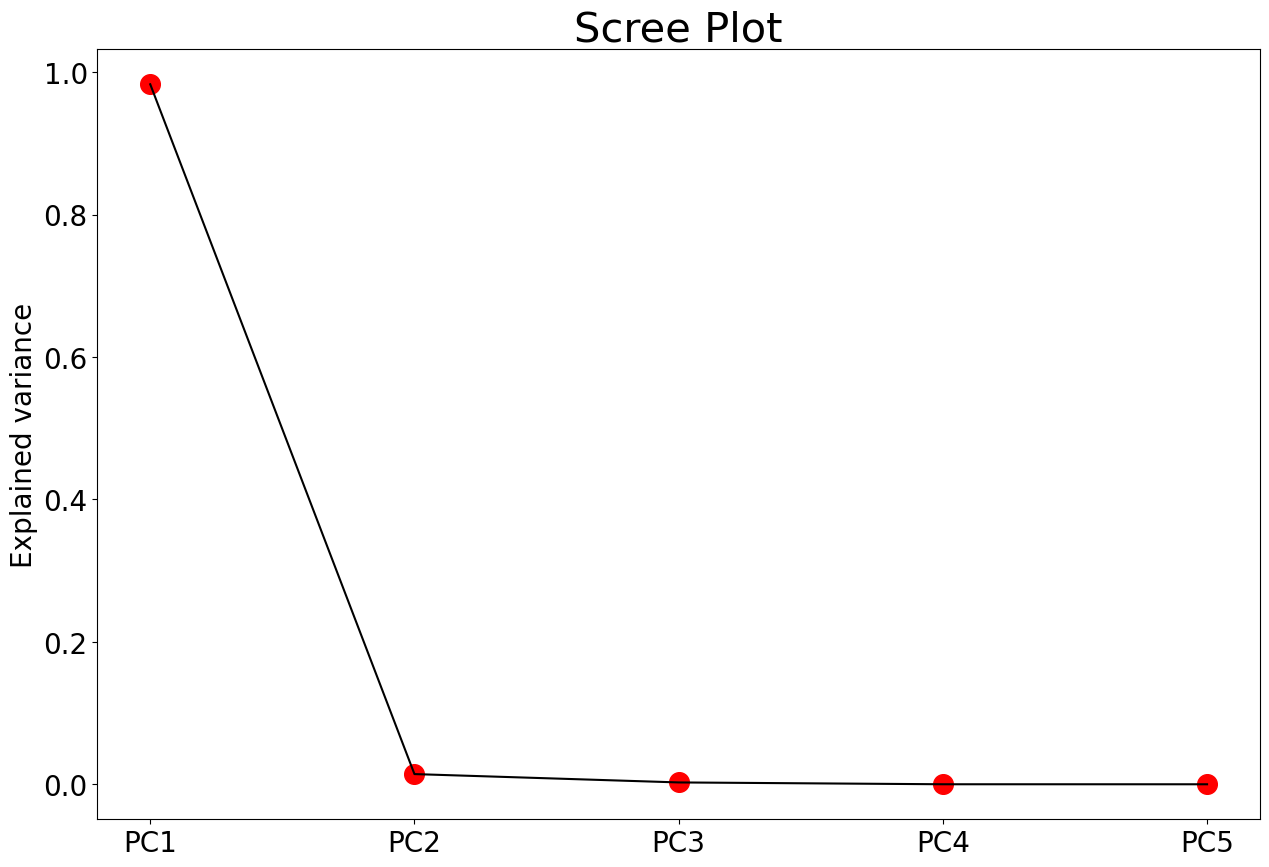

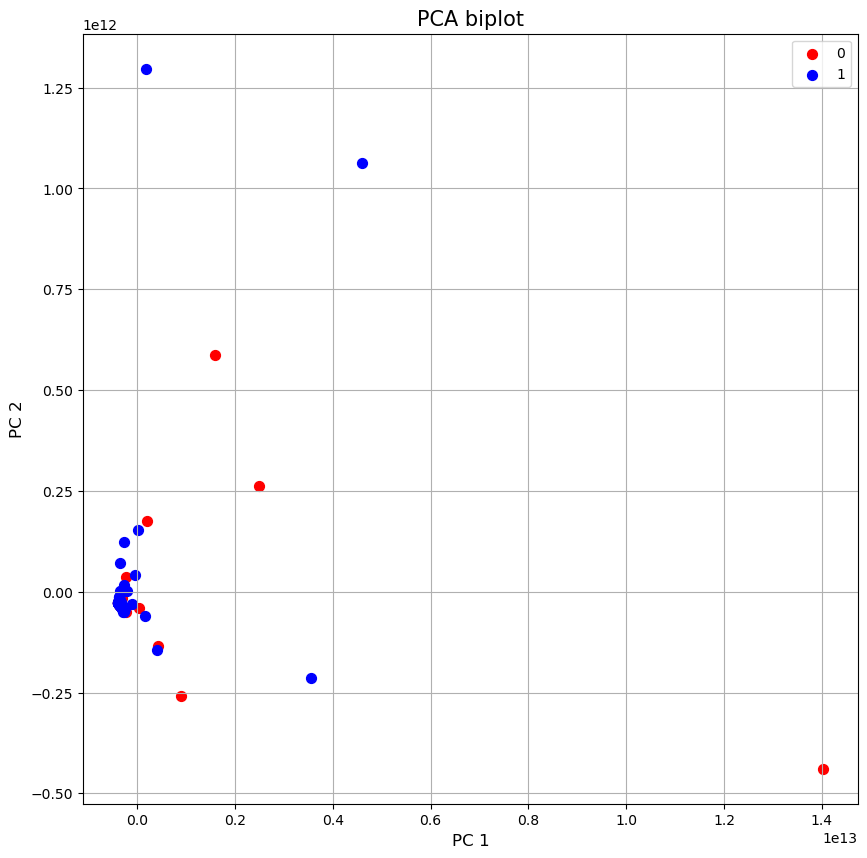

In [16]:
pca = PCA(n_components=5)
pca_fit = pca.fit_transform(df_total_train_data)
pca_fit_df = pd.DataFrame(data = pca_fit,
                          columns = ['principal component 1',
                                     'principal component 2',
                                     'principal component 3',
                                     'principal component 4',
                                     'principal component 5'])
pca_fit_df['response'] = y_train

fig, ax = plt.subplots(figsize=(15, 10))
plt.scatter(np.arange(len(pca.explained_variance_ratio_)),
            pca.explained_variance_ratio_, color='red', s=200)
plt.plot(np.arange(len(pca.explained_variance_ratio_)),
         pca.explained_variance_ratio_, color='black')
plt.xticks(np.arange(len(pca.explained_variance_ratio_)),
           ['PC'+str(i) for i in range(1,6)], fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('Explained variance', fontsize=20)
plt.title('Scree Plot',fontsize=30)
plt.show()

fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('PC 1', fontsize = 12)
ax.set_ylabel('PC 2', fontsize = 12)
ax.set_title('PCA biplot', fontsize = 15)
diags=[0,1]
colors=['r','b']
for diag, color in zip(diags,colors):
    i = pca_fit_df['response'] == diag
    ax.scatter(pca_fit_df.loc[i, 'principal component 1']
               , pca_fit_df.loc[i, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(diags)
ax.grid()


# Data preprocessing

In [17]:
# Preprocessing pipeline 
categoric_variables = ['SEXO_Mujer', 'TABAQUISMO_No', 'TABAQUISMO_Si', 'ENOLISMO_No', 'ENOLISMO_Si', 'DM_Si', 'HTA_Si', 'DLP_Si', 'PATOLOGIA PULMONAR_Si', 'PATOLOGIA CARDÍACA_Si', 'ANTC ONCO_Si', 'Tipo de lesion _PD pulmón ', 'Tipo de lesion _Primario sin antc', 'HISTOLOGIA_CEC', 'HISTOLOGIA_NoAP', 'HISTOLOGIA_Otros', 'LOCALIZACIÓN _LII', 'LOCALIZACIÓN _LMD', 'LOCALIZACIÓN _LSD', 'LOCALIZACIÓN _LSI']
numeric_variables = [col for col in df_total_train_data.columns if col not in categoric_variables]

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

preprocessing_pipeline = ColumnTransformer(
    transformers=[
       ('num', numeric_transformer, numeric_variables), 
       ('cat', 'passthrough', categoric_variables), 
    ]
)

##Data preprocessing
df_total_train_data_preprocessed = preprocessing_pipeline.fit_transform(df_total_train_data)
df_total_train_data_preprocessed = pd.DataFrame(df_total_train_data_preprocessed, columns=numeric_variables + categoric_variables)

df_total_test_data_preprocessed = preprocessing_pipeline.transform(df_total_test_data)
df_total_test_data_preprocessed = pd.DataFrame(df_total_test_data_preprocessed, columns=numeric_variables + categoric_variables)

In [18]:
df_total_train_data_preprocessed.head

<bound method NDFrame.head of      DOSIS TOTAL(GY)      EDAD  exponential_firstorder_10Percentile  \
0          -1.215888  0.255007                             0.554849   
1           0.861896  0.580290                            -1.064463   
2          -1.215888 -0.070277                             1.256530   
3          -0.384775 -0.460618                             0.472820   
4           0.861896 -0.525675                            -1.206760   
..               ...       ...                                  ...   
103         0.861896 -0.525675                            -0.362471   
104         0.861896  0.124893                             0.638098   
105        -1.215888 -4.559195                             1.566147   
106        -1.215888  0.710404                             0.582356   
107         0.861896  0.710404                            -0.260125   

     exponential_firstorder_90Percentile  exponential_firstorder_Energy  \
0                              -0.218689  

In [ ]:
corr = df_total_train_data_preprocessed.corr()
plt.figure(figsize=(15,10))
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
            cmap="BuPu",
            vmin=-1,
            vmax=1,
            annot=True)
plt.title("Correlation Heatmap")
plt.show()

In [19]:
df_total_train_data_preprocessed.to_excel("Preprocessed_data_train.xlsx")
df_total_train_data_preprocessed.shape

df_total_test_data_preprocessed.to_excel("Preprocessed_data_test.xlsx")
df_total_test_data_preprocessed.shape

y_train.to_excel("y_train.xlsx")
y_test.to_excel("y_test.xlsx")